In [392]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import os
import matplotlib.pyplot as plt

In [393]:
tf.keras.backend.clear_session()

In [394]:
base_dir = 'dataset\\'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')

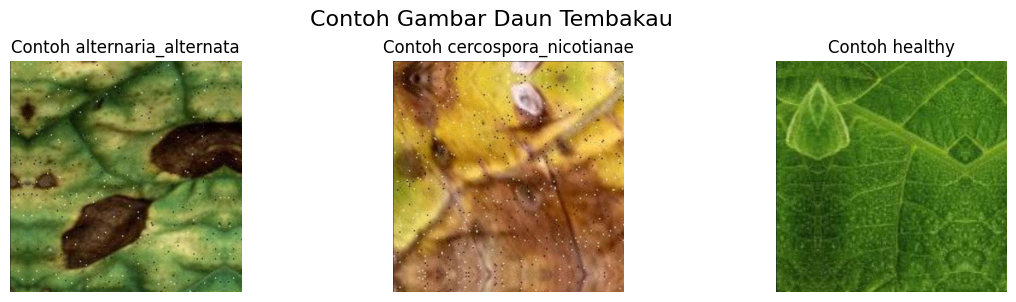

In [395]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
fig.suptitle('Contoh Gambar Daun Tembakau', fontsize=16, y=1.05)
classes = ['alternaria_alternata', 'cercospora_nicotianae', 'healthy']

for ii, class_name in enumerate(classes):
    dir = f'dataset/train/{class_name}'
    img_path = os.path.join(dir, os.listdir(dir)[0])  # Menggunakan os.path.join untuk keamanan
    img = tf.keras.preprocessing.image.load_img(img_path)
    axes[ii].imshow(img)
    axes[ii].set_title(f'Contoh {class_name}')
    axes[ii].axis('off')

plt.show()

In [396]:
sample_array = tf.keras.preprocessing.image.img_to_array(img)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (640, 640, 3)


In [397]:
sample_array[0,:5]

array([[  0.,  21.,   0.],
       [ 66.,  93.,  38.],
       [ 54.,  83.,  19.],
       [ 62.,  96.,  22.],
       [ 68., 106.,  23.]], dtype=float32)

In [398]:
img_height, img_width = 224, 224
batch_size = 32

In [399]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1051 files belonging to 3 classes.


In [400]:
valid_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'valid'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 124 files belonging to 3 classes.


In [401]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2)
])

In [402]:
def preprocess_data(image, label):
    image = tf.image.resize(image, [img_height, img_width]) / 255.0
    return image, label

In [403]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.map(preprocess_data).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.map(preprocess_data).prefetch(buffer_size=tf.data.AUTOTUNE)

In [404]:
for images, labels in train_dataset.take(1):
         print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


In [405]:
model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\laragon\bin\python\Python-3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [406]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [407]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,561,795 (105.14 MB)

 Trainable params: 12,847,107 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [408]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

In [409]:
import os

def count_files_in_directory(directory):
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif'}
    total_count = 0
    for root, _, files in os.walk(directory):
        total_count += sum(1 for file in files if os.path.splitext(file)[1].lower() in image_extensions)
    return total_count


train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')  


num_train_samples = count_files_in_directory(train_dir)
num_valid_samples = count_files_in_directory(valid_dir)


steps_per_epoch = num_train_samples // batch_size
validation_steps = num_valid_samples // batch_size

print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_valid_samples)
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)


Number of training samples: 1051
Number of validation samples: 124
Steps per epoch: 32
Validation steps: 3


In [420]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[reduce_lr],
    verbose=1
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 225s 6s/step - accuracy: 0.8335 - loss: 0.3769 - val_accuracy: 0.7500 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9259 - loss: 0.2847 - val_accuracy: 0.6429 - val_loss: 0.8464 - learning_rate: 0.0010
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 190s 6s/step - accuracy: 0.8634 - loss: 0.3460 - val_accuracy: 0.6771 - val_loss: 0.6922 - learning_rate: 0.0010
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.9259 - loss: 0.2830 - val_accuracy: 0.8214 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 185s 6s/step - accuracy: 0.8660 - loss: 0.3366 - val_accuracy: 0.7188 - val_loss: 0.7193 - learning_rate: 0.0010
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.6667 - loss: 0.5581 - val_accuracy: 0.6429 - val_loss: 0.8045 - learning_rate: 0.0010
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.8518 - loss: 0.3610 - val

In [421]:
model.save('model.h5')

In [422]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(base_dir, 'test'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 92 files belonging to 3 classes.


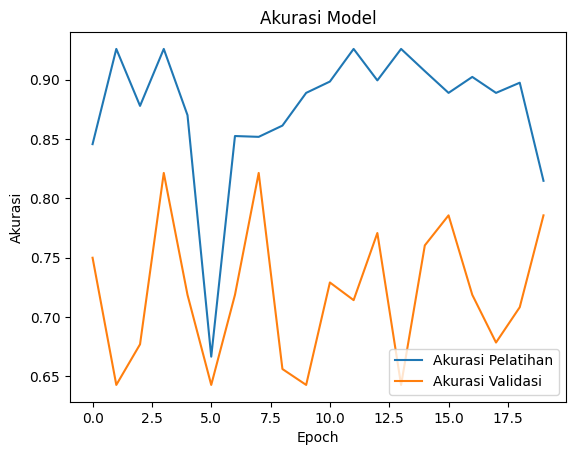

In [424]:
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()